In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
from sklearn.datasets import load_digits

In [3]:
#大样本数据的可视化是一个相对比较麻烦的事情，
#一般情况下我们都要用到降维的方法先处理特征。我们找一个例子来看看，可以怎么做，比如我们数据集取经典的『手写数字集』
#Each datapoint is a 8x8 image of a digit.
#Classes	10
#Samples per class	~180
#Samples total	1797
#Dimensionality	64
#Features	integers 0-16
digits = load_digits(n_class=7)#integer
X = digits.data
y = digits.target
n_samples,n_features = X.shape
print 'Dataset consist of %d samples with %d features each'% (n_samples,n_features)

Dataset consist of 1264 samples with 64 features each


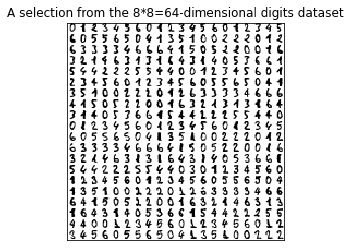

In [4]:
n_img_per_row = 20
img = np.zeros((10 * n_img_per_row, 10 * n_img_per_row))
for i in range(n_img_per_row):
    ix = 10 * i + 1
    for j in range(n_img_per_row):
        iy = 10 * j + 1
        img[ix:ix + 8, iy:iy + 8] = X[i * n_img_per_row + j].reshape((8, 8))
#20*20个数字X[:400]，每个占10*10，数字大小8*8，间隔是2
plt.imshow(img, cmap=plt.cm.binary)#本质是一堆数值点64个数值，根据数值大小体现不同的灰度
plt.xticks([])
plt.yticks([])
_ = plt.title('A selection from the 8*8=64-dimensional digits dataset')
plt.show()
#我们总共有1083个训练样本，包含手写数字(0,1,2,3,4,5)，每个样本图片中的像素点平铺开都是64位，这个维度显然是没办法直接可视化的。
#下面我们基于scikit-learn的示例教程对特征用各种方法做降维处理，再可视化。
#3种方法

In [5]:
#随机投射 
#我们先看看，把数据随机投射到两个维度上的结果
from sklearn import (manifold, decomposition, random_projection)


[[  0.   0.   5. ...,   0.   0.   0.]
 [  0.   0.   0. ...,  10.   0.   0.]
 [  0.   0.   0. ...,  16.   9.   0.]
 ..., 
 [  0.   0.   0. ...,   9.   0.   0.]
 [  0.   0.   0. ...,   4.   0.   0.]
 [  0.   0.   6. ...,   6.   0.   0.]] (1264, 64)


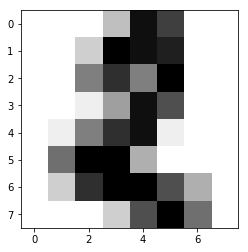

In [6]:
#每一行是一个手写数字，单独展示
print X,X.shape
image=np.zeros((8,8))
for i,value in enumerate(X[2,:]):
    xx = np.int(i/8)
    yy = i%8
    image[xx,yy]=value
plt.imshow(image,cmap=plt.cm.binary)
plt.show()

[[ 0.48        0.45454545]
 [ 0.48        0.06060606]
 [ 0.62        0.27272727]
 ..., 
 [ 0.42        0.03030303]
 [ 0.48        0.06060606]
 [ 0.64        0.33333333]]


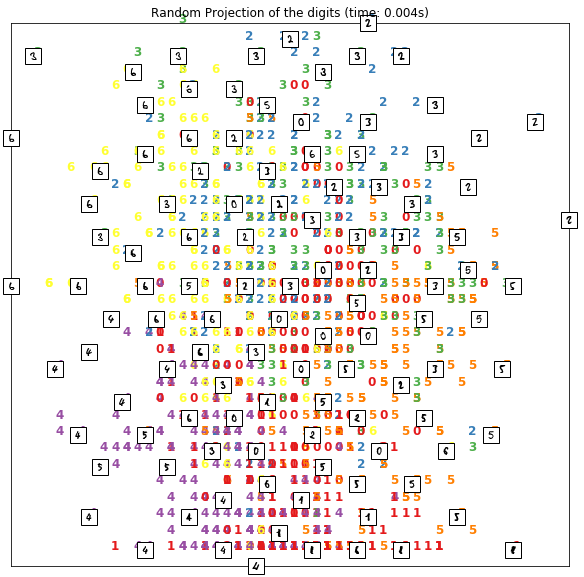

In [17]:
from matplotlib import offsetbox
from mpl_toolkits.mplot3d import Axes3D
def plot_embedding(X, title=None):
    x_min, x_max = np.min(X, 0), np.max(X, 0)
    X = (X - x_min) / (x_max - x_min)#正则化
    print X
    plt.figure(figsize=(10, 10))
    ax = plt.subplot(111)
    for i in range(X.shape[0]):
        plt.text(X[i, 0], X[i, 1], str(digits.target[i]),
                 color=plt.cm.Set1(y[i] / 10.),
                 fontdict={'weight': 'bold', 'size': 12})
    #打印彩色字体
    if hasattr(offsetbox, 'AnnotationBbox'):
        # only print thumbnails with matplotlib > 1.0
        shown_images = np.array([[1., 1.]])  # just something big
        for i in range(digits.data.shape[0]):
            dist = np.sum((X[i] - shown_images) ** 2, 1)
            if np.min(dist) < 4e-3:
                # don't show points that are too close
                continue
            shown_images = np.r_[shown_images, [X[i]]]
            imagebox = offsetbox.AnnotationBbox(
                offsetbox.OffsetImage(digits.images[i], cmap=plt.cm.gray_r),
                X[i])
            ax.add_artist(imagebox)#输出图上输出图片
    plt.xticks([]), plt.yticks([])
    if title is not None:
        plt.title(title)

def plot_embedding_3d(X, title=None): 
    #坐标缩放到[0,1]区间 
    x_min, x_max = np.min(X,axis=0), np.max(X,axis=0) 
    X= (X - x_min) / (x_max - x_min) #降维后的坐标为（X[i, 0], X[i, 1],X[i,2]），在该位置画出对应的digits 
    fig = plt.figure()
    ax = Axes3D(fig)
    for i in range(X.shape[0]): 
        ax.text(X[i, 0], X[i, 1], X[i,2],str(digits.target[i]), 
                color=plt.cm.Set1(y[i] / 10.), 
                fontdict={'weight': 'bold', 'size': 9}) 
    if title is not None: 
            plt.title(title)
#记录开始时间
rp = random_projection.SparseRandomProjection(n_components=2, random_state=42)#随机映射算法
start_time = time.time()
X_projected = rp.fit_transform(X)#随机投射
plot_embedding(X_projected, "Random Projection of the digits (time: %.3fs)" % (time.time() - start_time))
plt.show()

[[ 0.29204868  0.61150719]
 [ 0.55012603  0.4271002 ]
 [ 0.54872692  0.49229304]
 ..., 
 [ 0.47322772  0.95991451]
 [ 0.55749629  0.98473428]
 [ 0.77934603  0.70698035]]


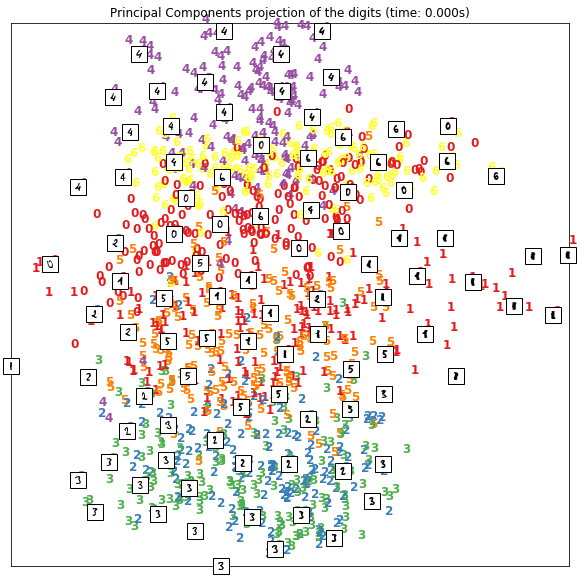

In [13]:
#PCA降维 
#在维度约减/降维领域有一个非常强大的算法叫做PCA(Principal Component Analysis，主成分分析)，
#它能将原始的绝大多数信息用维度远低于原始维度的几个主成分表示出来。
#PCA在我们现在的数据集上效果还不错，我们来看看用PCA对原始特征降维至2维后，原始样本在空间的分布状况：
from sklearn import (manifold, decomposition, random_projection)
#TruncatedSVD 是 PCA的一种实现
X_pca = decomposition.TruncatedSVD(n_components=2).fit_transform(X)
#记录时间​TruncatedSVD
start_time = time.time()
plot_embedding(X_pca,"Principal Components projection of the digits (time: %.3fs)" % (time.time() - start_time))
plt.show()

[[ 0.61699574  0.109982  ]
 [ 0.46178814  0.99910616]
 [ 0.46235739  0.67709753]
 ..., 
 [ 0.96482701  0.65601647]
 [ 0.93201683  0.65773356]
 [ 0.7371917   0.1061135 ]]


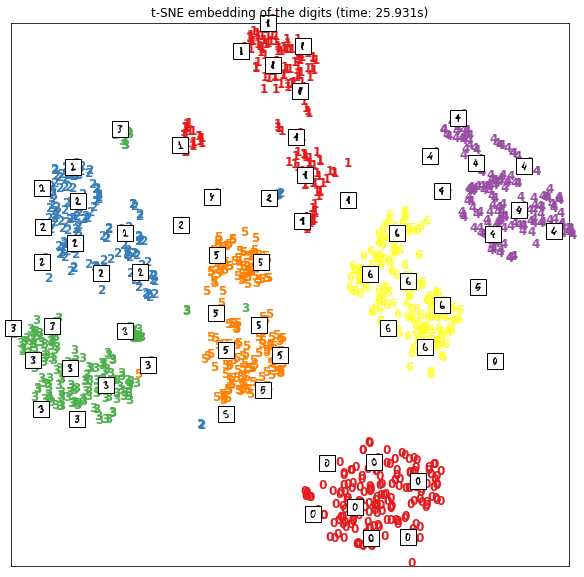

In [9]:
#效果还不错，不同的手写数字在2维平面上，显示出了区域集中性。即使它们之间有一定的重叠区域。
#如果我们用一些非线性的变换来做降维操作，从原始的64维降到2维空间，效果更好，比如这里我们用到一个技术叫做t-SNE，sklearn的manifold对其进行了实现：
from sklearn import (manifold, decomposition, random_projection)
#降维
tsne = manifold.TSNE(n_components=2, init='pca', random_state=0)
start_time = time.time()
X_tsne = tsne.fit_transform(X)
#绘图
plot_embedding(X_tsne,
               "t-SNE embedding of the digits (time: %.3fs)" % (time.time() - start_time))
plt.show()
#这个非线性变换降维过后，仅仅2维的特征，就可以将原始数据的不同类别，在平面上很好地划分开。
#不过t-SNE也有它的缺点，一般说来，相对于线性变换的降维，它需要更多的计算时间。

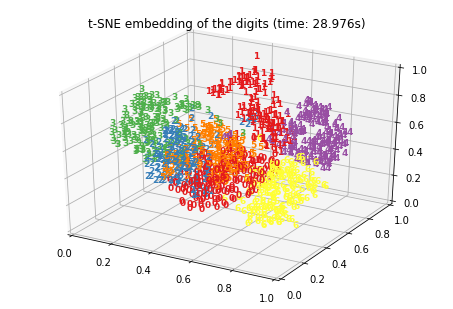

In [18]:
tsne_3d = manifold.TSNE(n_components=3,init='pca',random_state=0)
start_time = time.time()
X_tsne_3d = tsne_3d.fit_transform(X)
#绘图
plot_embedding_3d(X_tsne_3d,
               "t-SNE embedding of the digits (time: %.3fs)" % (time.time() - start_time))
plt.show()